# IMPORTAÇÃO DOS MÓDULOS E CONFIGURAÇÃO


In [314]:
import numpy as np
import pandas as pd
# from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline
import sys
import os

# Adiciona o diretório pai (onde está dropout_rate_project) ao sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # Isso permite que o notebook enxergue a pasta dropout_rate_project.

from dropout_rate_project.py_files import data_prepared as dp
from dropout_rate_project.py_files import adjusted_models_util as amu
from dropout_rate_project.py_files import define_models_util as dmu


# CONFIGURAÇÃO DOS DADOS E MODELO

In [315]:
# Configuração dos dados

dados = '../data/selected_data.csv'
reference_year = 2023
drop_year=[]
random_state = 0
data_filter = True
concat_inputs = True
model_test = "Logistic_Regression"


In [316]:
if model_test == "Logistic_Regression":
  # base model
  label_pipeline = 'logreg'
  base_model = LogisticRegression(class_weight='balanced', random_state=random_state, fit_intercept=True)

  # Criando o modelo com os hiperparâmetros ajustados para o melhor modelo de logistic regression definido para o teste
  base_model.C=10
  base_model.max_iter=100
  base_model.penalty='l2'
  base_model.solver='sag'
  #base_model.l1_ratio=0.5

if model_test == "Decision_Tree":
  # base model
  label_pipeline = 'decision_tree'
  base_model = DecisionTreeClassifier(class_weight='balanced', random_state=random_state)

  # Criando o modelo com os hiperparâmetros ajustados para o melhor modelo de logistic regression definido para o teste
  base_model.criterion = 'gini'
  base_model.max_depth = 5 
  base_model.max_features = None
  base_model.min_samples_leaf = 5
  base_model.min_samples_split = 2
  
if model_test == "Random_Forest":
  # base model
  label_pipeline = 'random_forest'
  base_model = RandomForestClassifier(class_weight='balanced', random_state=random_state)

  # Criando o modelo com os hiperparâmetros ajustados para o melhor modelo de logistic regression definido para o teste
  base_model.bootstrap = True
  base_model.criterion = 'entropy'
  base_model.max_depth = 3 
  base_model.max_features = None
  base_model.min_samples_leaf = 3
  base_model.min_samples_split = 10
  base_model.n_estimators = 100

if model_test == "svm":

  # base model
  label_pipeline = 'svm'
  base_model = SVC(class_weight='balanced', random_state=random_state)

  # Criando o modelo com os hiperparâmetros ajustados para o melhor modelo de logistic regression definido para o teste
  base_model.C = 100
  base_model.degree = 2
  base_model.gamma = 'scale' 
  base_model.kernel = 'linear'
  base_model.probability = True

if model_test == "XG_Boost":

  # base model
  label_pipeline = 'xgboost'
  base_model = XGBClassifier(use_label_encoder=True, eval_metric='logloss', random_state=random_state, scale_pos_weight=2344/1462)
  base_model.gamma = 0.2
  base_model.learning_rate = 0.01
  base_model.max_depth = 3
  base_model.n_estimators = 250
  base_model.reg_alpha = 0
  base_model.reg_lambda = 1

if model_test == "KNN":

  # base model
  label_pipeline = 'knn'
  base_model = KNeighborsClassifier()
  base_model.n_neighbors = 7
  base_model.weights = 'uniform'
  base_model.metric = 'manhattan'
  base_model.p = 1


test_model = base_model
test_pipeline = {
    'model': test_model,  # ou o seu modelo
    'optimal_threshold':0.72,
    'best_threshold_tpr':0.11
}





In [317]:

# Gráficos para variáveis categóricas
categorical_features = ['RF-CAT', 'SEXO', 'TC', 'NC', 'TO', 'ME','TURNO']

# Gráficos para variáveis numéricas
numerical_features = ['IDA-MÉD']

df = pd.read_csv(dados)

if data_filter:
  # Exemplo de uso:
  df_filtrado = dp.filter_dataframe_by_column(df, 'TO', 'SUB')
  df=df_filtrado
  print(df_filtrado)

if concat_inputs:
  df["RFCAT_SEXO_TC_NC_TO_ME_TURNO"] = df[["RF-CAT","SEXO","TC", "NC", "TO", "ME", "TURNO"]].astype(str).agg("-".join, axis=1)
  df = df[["IDA-MÉD","RFCAT_SEXO_TC_NC_TO_ME_TURNO","ANO","AE"]]
  categorical_features = ["IDA-MÉD","RFCAT_SEXO_TC_NC_TO_ME_TURNO"]


df.head(-5)

     RF-CAT SEXO  IDA-MÉD   TC   NC   TO ME TURNO   ANO  AE
0        ND    M     47.0  TÉC  PES  SUB  P   VES  2017   1
2       0,5    F     17.0  TÉC   GT  SUB  P   VES  2017   0
3       0,5    F     17.0  TÉC   SJ  SUB  P   VES  2017   0
4       0,5    F     17.0  TÉC   SJ  SUB  P   VES  2017   0
5       0,5    F     17.0  TÉC   TI  SUB  P   VES  2017   0
...     ...  ...      ...  ...  ...  ... ..   ...   ...  ..
5711     ND    M     42.0  TÉC   GT  SUB  P   INT  2023   0
5712     ND    M     42.0  TÉC   SJ  SUB  D   NSA  2023   0
5713     ND    M     47.0  TÉC   GT  SUB  P   INT  2023   0
5714      1    F     27.0  TÉC   CE  SUB  D   NSA  2023   1
5718      1    F     37.0  TÉC   CE  SUB  D   NSA  2023   1

[2589 rows x 10 columns]


,IDA-MÉD,RFCAT_SEXO_TC_NC_TO_ME_TURNO,ANO,AE
0,47.0,ND-M-TÉC-PES-SUB-P-VES,2017,1
2,17.0,"0,5-F-TÉC-GT-SUB-P-VES",2017,0
3,17.0,"0,5-F-TÉC-SJ-SUB-P-VES",2017,0
4,17.0,"0,5-F-TÉC-SJ-SUB-P-VES",2017,0
5,17.0,"0,5-F-TÉC-TI-SUB-P-VES",2017,0
...,...,...,...,...
5698,37.0,ND-F-TÉC-SJ-SUB-P-NOT,2023,1
5699,42.0,ND-F-TÉC-GT-SUB-P-INT,2023,0
5702,47.0,ND-F-TÉC-GT-SUB-P-INT,2023,0
5708,27.0,ND-M-TÉC-GT-SUB-P-INT,2023,0


# PREPARAÇÃO DOS DADOS DE TREINO E TESTE

---



In [318]:
# Separação dos dados de treino e teste
df_train, df_test, features_train, target_train, features_test, target_test = dp.get_df_train_df_test(df, reference_year, drop_year )

In [319]:
# Chamada da função com os DataFrames de treino e teste
dp.show_dataset_information(df_train, df_test)

Conjunto de treino: 2312
Conjunto de teste: 277
Shape do conjunto de treino: (2312, 3)
Valores nulos no conjunto de treino:
IDA-MÉD                         0
RFCAT_SEXO_TC_NC_TO_ME_TURNO    0
AE                              0
dtype: int64

Tipos de dados no conjunto de treino:
IDA-MÉD                         float64
RFCAT_SEXO_TC_NC_TO_ME_TURNO     object
AE                                int64
dtype: object

Colunas com valores nulos:
Series([], dtype: int64)


In [320]:
# Criando os pipeline de treino e validação para os melhores hiperparâmetros avaliados por penalidade
# import preprocess_util as amu

from sklearn.model_selection import cross_val_score

X = features_train
y = target_train

# ANÁLISE DOS DADOS DE TESTE



In [321]:
df_test.head(5)

,IDA-MÉD,RFCAT_SEXO_TC_NC_TO_ME_TURNO,AE
4905,27.0,ND-F-TÉC-GT-SUB-P-INT,0
4915,22.0,"0,5-F-TÉC-CE-SUB-D-NSA",1
4916,22.0,"0,5-F-TÉC-GT-SUB-P-VES",0
4917,22.0,"0,5-F-TÉC-GT-SUB-P-INT",0
4918,22.0,"0,5-F-TÉC-SJ-SUB-D-NSA",1


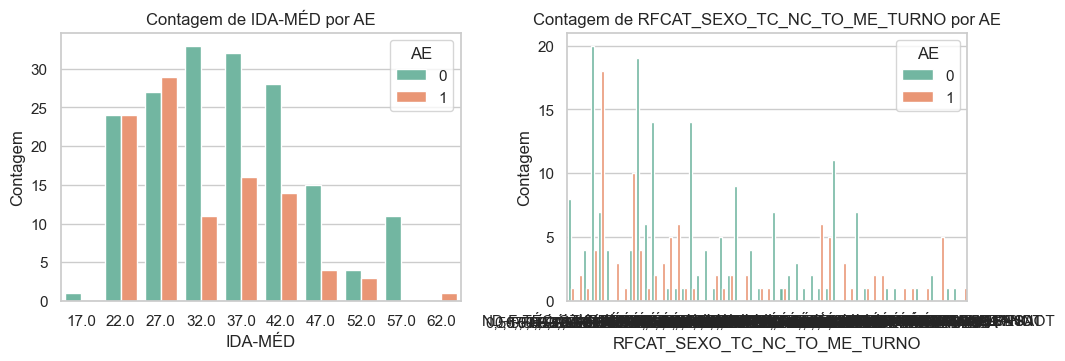

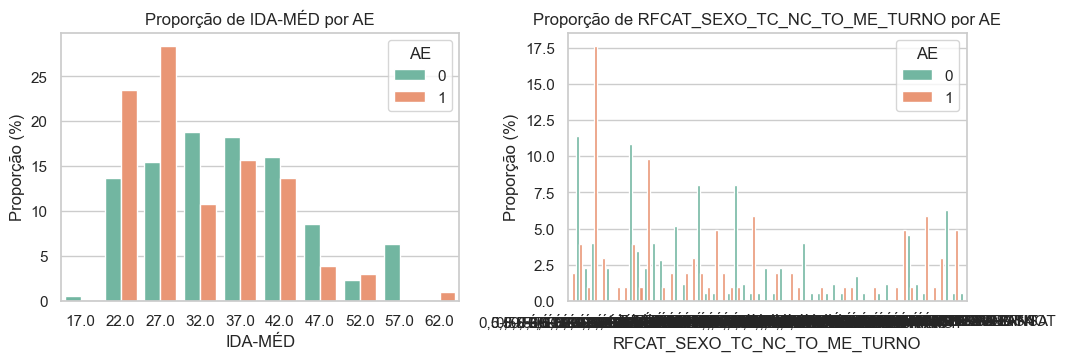

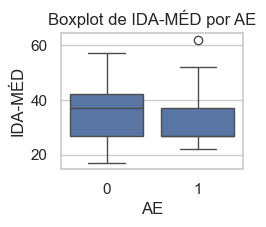

Descrição das Variáveis Numéricas:
          IDA-MÉD          AE
count  277.000000  277.000000
mean    34.220217    0.368231
std      9.576081    0.483198
min     17.000000    0.000000
25%     27.000000    0.000000
50%     32.000000    0.000000
75%     42.000000    1.000000
max     62.000000    1.000000

Descrição das Variáveis Categóricas:

Frequência de valores em RFCAT_SEXO_TC_NC_TO_ME_TURNO:
RFCAT_SEXO_TC_NC_TO_ME_TURNO
0,5-F-TÉC-SJ-SUB-D-NSA    25
0,5-F-TÉC-GT-SUB-P-INT    24
0,5-M-TÉC-GT-SUB-P-INT    23
1-F-TÉC-GT-SUB-P-INT      16
1-M-TÉC-GT-SUB-P-INT      15
0,5-M-TÉC-SJ-SUB-D-NSA    14
ND-M-TÉC-GT-SUB-P-INT     11
1,5-M-TÉC-GT-SUB-P-INT     9
ND-F-TÉC-GT-SUB-P-INT      9
2,5-M-TÉC-GT-SUB-P-INT     7
ND-F-TÉC-SJ-SUB-D-NSA      7
1-M-TÉC-SJ-SUB-D-NSA       7
0,5-M-TÉC-GT-SUB-P-VES     7
0,5-M-TÉC-TA-SUB-P-NOT     7
1,5-F-TÉC-GT-SUB-P-INT     6
ND-M-TÉC-SJ-SUB-D-NSA      6
1-F-TÉC-SJ-SUB-D-NSA       6
0,5-F-TÉC-GT-SUB-P-VES     5
ND-F-TÉC-CE-SUB-D-NSA      5
0,5-F-TÉC-TA-SUB-P-NO

In [322]:
dp.plot_data_exploration_from_categorical_features_to_drop_rate(categorical_features, df_test)
dp.plot_data_exploration_from_categorical_features_to_drop_rate_percent(categorical_features, df_test)
dp.plot_data_exploration_from_numerical_features_to_drop_rate(numerical_features, df_test)
dp.get_description(df_test)
dp.show_and_drop_missing_values(df_test)

# AVALIAÇÃO DO MODELO NOS DADOS DE TESTE

In [323]:
# configuração do modelo para o melhor threshold auc e recall
best_model = test_pipeline['model']
best_threshold = test_pipeline['optimal_threshold']
best_threshold_tpr = test_pipeline['best_threshold_tpr']

              precision    recall  f1-score   support

           0       0.64      0.98      0.77       175
           1       0.62      0.05      0.09       102

    accuracy                           0.64       277
   macro avg       0.63      0.52      0.43       277
weighted avg       0.63      0.64      0.52       277

AUC: 0.52
[[172   3]
 [ 97   5]]


d:\Dropbox\Documentos\IFPB\Pesquisa\Taxa de Evasão\Dropout Rate Project\dropout_rate_project\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


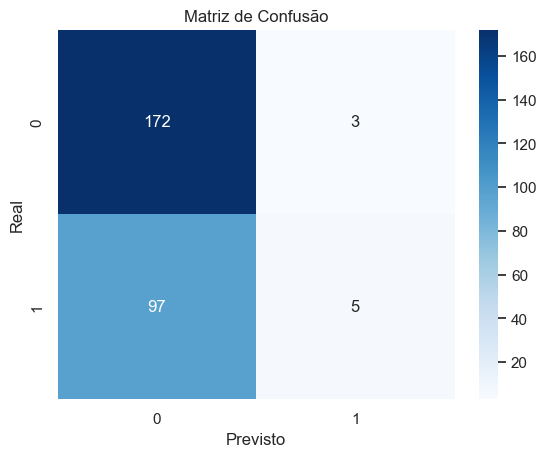

modelo: Logistic_Regression
data_filter: True
concat_inputs: True
ano: (2023, [])
features_train (2312, 2)
target_train (2312,)
features_test (277, 2)
target_test (277,)
model: {'C': 10, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'sag', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
best_threshold 0.72 
best_threshold_tpr 0.11 
média auc: 0.5159383753501401
desvio padrão auc: 0.0
média f1: 0.09090909090909091
desvio padrão f1: 0.0
média recall: 0.049019607843137254
desvio padrão recall: 0.0
média precision: 0.625
desvio padrão precision: 0.0
média accuracy: 0.6389891696750902
desvio padrão accuracy: 0.0


In [324]:
results_auc = []
results_f1 = []
results_recall = []
results_precision = []
results_accuracy = []
to_print = True
pipeline_best_model = None
# criando pipeline para modelo com todos os dados
#for i in range(1):
if model_test != "KNN": best_model.random_state=random_state
pipeline_best_model = amu.create_model_pipeline(best_model,features_train,target_train)
auc, f1, recall, precision, accuracy = amu.evaluate_model(pipeline_best_model,features_test,target_test, best_threshold, to_print)
results_auc.append(auc)
results_f1.append(f1)
results_recall.append(recall)
results_precision.append(precision)
results_accuracy.append(accuracy)



# Exibindo os resultados
"""for idx in range(30):
  print(f"Resultados para random_state={idx}:")
  print(f"auc: {idx} {results_auc[idx]}")
  print(f"auc: {idx} {results_f1[idx]}")
  print(f"auc: {idx} {results_recall[idx]}")
  print(f"auc: {idx} {results_precision[idx]}")
  print(f"auc: {idx} {results_accuracy[idx]}")"""

print(f"modelo: {model_test}")
print(f"data_filter: {data_filter}")
print(f"concat_inputs: {concat_inputs}")
print(f"ano: {reference_year, drop_year}")
print("features_train",features_train.shape)
print("target_train", target_train.shape)
print("features_test",features_test.shape)
print("target_test", target_test.shape)
print(f"model: {best_model.get_params()}")
print(f"best_threshold {best_threshold} ")
print(f"best_threshold_tpr {best_threshold_tpr} ")
print(f"média auc: {np.mean(results_auc)}")
print(f"desvio padrão auc: {np.std(results_auc)}")
print(f"média f1: {np.mean(results_f1)}")
print(f"desvio padrão f1: {np.std(results_f1)}")
print(f"média recall: {np.mean(results_recall)}")
print(f"desvio padrão recall: {np.std(results_recall)}")
print(f"média precision: {np.mean(results_precision)}")
print(f"desvio padrão precision: {np.std(results_precision)}")
print(f"média accuracy: {np.mean(results_accuracy)}")
print(f"desvio padrão accuracy: {np.std(results_accuracy)}")

